<div style="display: flex;">
    <div style="width:100px; text-align:center;">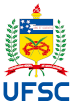</div>
    <div style="width: 100%; text-align: center;"><h1>Universidade Federal de Santa Catarina<br/>Centro Tecnológico<br/>Departamento de Informática e Estatística</h1></div>
    <div style="width:100px; text-align:center;">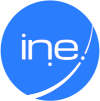</div>
</div>

<h3><strong>Disciplina:</strong> INE5664 - Aprendizado de Máquina<br/>
<strong>Turma:</strong> 07238<br/>
<strong>Curso:</strong> Sistemas de Informação<br/>
<strong>Professor:</strong> Eduardo Camilo Inacio<br/>
<strong>Alunos:</strong> Acaua Pitta, Isac Martins, Lucas Cunha</h3>

<h2>Processo de Regressão com Rede Neural Personalizada</h2>

In [ ]:
### Instalação de Pacotes
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

### Configuração do Caminho
import sys
import os

sys.path.append(os.path.abspath('../src'))


### Importação de Bibliotecas
import numpy as np
import pandas as pd
from neural_network.neural import NeuralNetwork
from neural_network.layers.dense_layer import DenseLayer
from neural_network.layers.dropout_layer import DropoutLayer
from neural_network.optimizer import GradientDescent
from neural_network.losses import CrossEntropyLoss,MeanSquaredError
from neural_network.utils import normalize_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ( accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, mean_absolute_error,
    mean_squared_error, r2_score
)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.9 MB/s eta 0:00:00MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Leitura do Dataset
df = pd.read_csv('../data/regression/student-por.csv')

### Seleciona apenas as colunas especificadas, além do alvo 'G3'
selected_columns = ['G1', 'G2', 'G3', 'failures', 'studytime', 'Medu', 'Fedu', 'Dalc', 'Walc']
df = df[selected_columns]

### Normalização dos dados numéricos

### Instancia o objeto para padronização (média = 0, desvio padrão = 1)
scaler = StandardScaler()

### Define as colunas numéricas que serão normalizadas
numerical_cols = ['G1', 'G2', 'failures', 'studytime', 'Medu', 'Fedu', 'Dalc', 'Walc']


### Aplica a padronização às colunas numéricas
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Separação de recursos (X) e variável alvo (y)

### Remove a coluna 'G3' (variável alvo) de X
X = df.drop(columns=['G3'])

### Define 'G3' como a variável alvo
y = df['G3']


### Divisão em conjuntos de treinamento e teste

### Divide os dados em conjunto de treinamento (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

Numerical Columns Scaled: ['G1', 'G2', 'failures', 'studytime', 'Medu', 'Fedu', 'Dalc', 'Walc']
Shape of X_train: (519, 8)
Shape of X_test: (130, 8)
Shape of y_train: (519,)
Shape of y_test: (130,)


In [ ]:
<h3>Configuração da Rede Neural para Regressão</h3>

In [ ]:
### Obtém o número de características de entrada do conjunto de treinamento
input_size = X_train.shape[1]

### Definição da arquitetura da rede neural
layers = [
    ### Primeira camada densa com 64 neurônios e ativação ReLU
    DenseLayer(input_size=input_size, output_size=64, activation='relu'), 
    ### Dropout de 30% para evitar overfitting
    DropoutLayer(rate=0.3),  
    
    ### Segunda camada densa com 32 neurônios e ativação ReLU
    DenseLayer(input_size=64, output_size=32, activation='relu'), 
    ### Dropout de 30%
    DropoutLayer(rate=0.3),
    
    ### Terceira camada densa com 16 neurônios e ativação ReLU
    DenseLayer(input_size=32, output_size=16, activation='relu'),  
    ### Dropout de 20%
    DropoutLayer(rate=0.2),

    ### Quarta camada densa com 8 neurônios e ativação ReLU
    DenseLayer(input_size=16, output_size=8, activation='relu'), 
    
    ### Última camada densa com 1 neurônio (saída para regressão) e ativação linear
    DenseLayer(input_size=8, output_size=1, activation='linear') 
]

### Definição da função de perda para regressão (Erro Quadrático Médio)
loss = MeanSquaredError()

### Definição do otimizador com taxa de aprendizado de 0.01
optimizer = GradientDescent(learning_rate=0.01)

### Inicializa o modelo de rede neural com as camadas, função de perda e otimizador definidos
model = NeuralNetwork(layers=layers, loss=loss, optimizer=optimizer)

In [ ]:
<h3>Treinamento do Modelo com Critério de Convergência

In [ ]:
import numpy as np

### Converte os dados de treinamento para arrays NumPy de tipo float
X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=float).reshape(-1, 1)

### Inicializa variáveis para controle do treinamento
epoch = 0                     # Contador de épocas
previous_loss = float('inf')  # Inicializa a perda anterior como infinito
convergence_threshold = 0.85  # R² mínimo para considerar o modelo como convergido
r2 = 0                        # Inicializa o valor de R²

### Laço de treinamento
while r2 < convergence_threshold: # Continua treinando até atingir o R² desejado
    epoch += 1 # Incrementa o contador de épocas
    
    ### Passagem para frente (forward pass): calcula as previsões
    predictions = model.forward(X_train)
    
    ### Calcula a perda usando a função de perda definida
    loss_value = loss.calculate(y_train, predictions)
    
    ### Passagem para trás (backward pass): calcula os gradientes
    model.backward(y_train, predictions)
    
    ### Atualiza os pesos da rede neural usando o otimizador
    model.update()
    
    ### A cada 10 épocas, calcula métricas adicionais para monitoramento
    if epoch % 10 == 0:
        predictions_flat = predictions.flatten() # Achata as previsões para facilitar
        y_true = y_train.flatten() # Achata os valores reais
        
        ### Cálculo do erro absoluto médio (MAE)
        mean_absolute_error = np.mean(np.abs(y_true - predictions_flat))
        
        ### Cálculo do coeficiente de determinação R²
        ss_res = np.sum((y_true - predictions_flat) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0
        
        ### Imprime as métricas da época atual
        print(f'Epoch {epoch:04d} | Loss: {loss_value:.4f} | MAE: {mean_absolute_error:.4f} | R²: {r2:.4f}')
    
    ### Verifica critério de convergência baseado na melhoria da perda
    if abs(previous_loss - loss_value) < 1e-6:  # Se a melhoria na perda for insignificante
        print("Converged: Loss improvement below threshold.") # Imprime mensagem de convergência
        break # Encerra o treinamento
    
    ### Atualiza a perda anterior para a próxima iteração
    previous_loss = loss_value

Epoch 0010 | Loss: 1.9490 | MAE: 1.0036 | R²: 0.8136
Epoch 0020 | Loss: 1.8309 | MAE: 0.9707 | R²: 0.8249
Epoch 0030 | Loss: 1.7308 | MAE: 0.9431 | R²: 0.8345
Epoch 0040 | Loss: 1.6396 | MAE: 0.9170 | R²: 0.8432
Epoch 0050 | Loss: 1.5500 | MAE: 0.8913 | R²: 0.8517


In [ ]:
<h3>Avaliação do Modelo e Visualização de Resultados</h3>

- Test Loss: 3.7329
- Mean Absolute Error (MAE): 1.4453
- Mean Squared Error (MSE): 3.7329
- Root Mean Squared Error (RMSE): 1.9321
- R-squared (R²): 0.6347


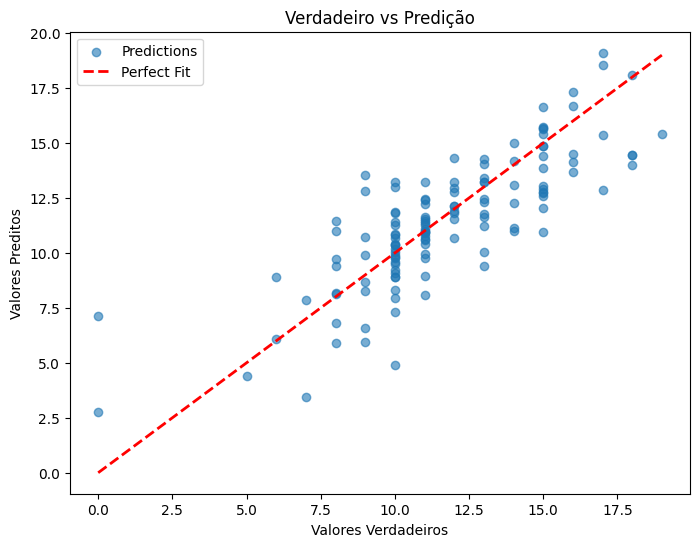

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

### Realiza previsões no conjunto de teste
y_pred_test = model.forward(X_test)

### Calcula a perda no conjunto de teste
test_loss = loss.calculate(y_test.values.reshape(-1, 1), y_pred_test)

### Calcula o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred_test.flatten())

### Calcula o erro quadrático médio (MSE)
mse = mean_squared_error(y_test.values, y_pred_test.flatten())

### Calcula a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)

### Calcula o coeficiente de determinação (R²)
r2 = r2_score(y_test.values, y_pred_test.flatten())  

### Exibe as métricas de avaliação no conjunto de teste
print(f"- Test Loss: {test_loss:.4f}")
print(f"- Mean Absolute Error (MAE): {mae:.4f}")
print(f"- Mean Squared Error (MSE): {mse:.4f}")
print(f"- Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"- R-squared (R²): {r2:.4f}")


### Visualiza os valores preditos versus os valores reais
plt.figure(figsize=(8, 6)) # Define o tamanho da figura
plt.scatter(y_test, y_pred_test, alpha=0.6, label='Predictions')  # Gráfico de dispersão dos valores reais vs preditos
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit') # Linha de ajuste perfeito
plt.xlabel('Valores Verdadeiros') # Rótulo do eixo X
plt.ylabel('Valores Preditos') # Rótulo do eixo Y
plt.title('Verdadeiro vs Predição') # Título do gráfico
plt.legend() # Adiciona a legenda ao gráfico
plt.show() # Mostra o gráfico

